<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; min-width: 250px; display: flex; justify-content: center;">
        <img src="https://adnova.novaims.unl.pt/media/22ui3ptm/logo.svg" style="max-width: 80%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 3rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style='color:#6f800f'> Data Mining Project | </span>
            <span style='color:#393B79'>ABCDEats Inc.</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Fall Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right,#6f800f, #393B79); 
            padding: .7px; color: white; border-radius: 300px; text-align: center;">
</div>

## 📚 Libraries Import

In [13]:
# For data
import pandas as pd
import numpy as np
import os

# For plotting and EDA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap

# For preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Set the style of the visualization
pd.set_option('display.max_columns', None)                  # display all columns
pd.set_option('display.float_format', lambda x: '%.2f' % x) # display floats with 2 decimal places

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
plt.style.use('ggplot')
sns.set_theme(style='white')

## **Review of [`Part 1`]('./DM2425_Part1_37.ipynb')**

> Before continuing with Part 2 - data preprocessing process, we believe it is important to highlight some of the changes and additions we made in Part 1, as they may be essential for this stage:

- We updated the description of the variable `is_chain` in the metadata to align with the values it takes. **<span style="color:red">querem também mudar o nome para chain_count?</span>**
- Removed 13 rows that were identified as duplicates.
- The value `'-'` in `customer_region` was replaced with `'Unknown'` to represent missing data.
- The value `'-'` in `last_promo` was considered equivalent to `'NO PROMO'`.

#### **Inconsistencies:**
- Number of cases where `vendor_count` is greater than `product_count`: 18 (0.06%).  
- Number of cases where `is_chain` is greater than `product_count`: 75 (0.24%).  
- Dropped 138 rows where the number of orders is zero.
- Number of cases where `order_count` is greater than `product_count`: 18 (0.06%), corresponding to the same cases where `vendor_count > product_count`.

#### **New Variables Created:**
- `Number of Orders`: Corresponds to the sum of the variables `DOW_0` to `DOW_6`.
- `customer_region_buckets`: Aggregated `customer_region` into buckets `2`, `4`, `8`, and `U`.
- `customer_age_group`: Age ranges grouped into buckets: `15-28`, `29-41`, `42-54`, `55-67`, `68-80`.
- `days_between_orders`: Calculated as the difference between `last_order` and `first_order`.
- `days_between_orders_per_order`: Represents the quotient between `days_between_orders` and `order_count`.
- `last_promo_bin`: Binary variable; takes the value `0` for `'NO PROMO'` and `1` otherwise.
- `CUI_Total_Amount_Spent`: Total spending across all cuisines during the study period.
- `CUI_Most_Spent_Cuisine`: Name of the cuisine where the customer spent the most money.
- `CUI_Total_Food_Types`: Count of different types of cuisines ordered.
- `CUI_Avg_Amount_Spent`: Quotient of `CUI_Total_Amount_Spent` by `order_count`.

# <a class='anchor' id='2'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #6f800f,#393B79); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>Part 2 | Data Preprocessing </b></h1></center>
</div>

In [14]:
# Importing the dataset
ABCDEats = pd.read_parquet('data/DM2425_ABCDEats_1stPart.parquet')

In [15]:
# Display the first 5 rows just to confirm the import was successful
ABCDEats.head() 

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,18.00,2,5,1,0.00,1,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.88,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,2,15-28,1.00,0.50,1,28.88,Indian,1,14.44
1,5d272b9dcb,8670,17.00,2,2,2,0.00,1,DISCOUNT,DIGI,12.82,6.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,8,15-28,1.00,0.50,1,19.21,American,2,9.61
2,f6d1b2ba63,4660,38.00,1,2,2,0.00,1,DISCOUNT,CASH,9.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,4,29-41,1.00,0.50,1,9.20,American,1,4.60
3,180c632ed8,4660,NaN,2,3,1,0.00,2,DELIVERY,DIGI,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,4,None,2.00,1.00,1,31.56,Indian,2,15.78
4,4eb37a6705,4660,20.00,2,5,0,0.00,2,NO PROMO,DIGI,14.57,40.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0.00,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,15-28,2.00,1.00,0,55.44,Asian,2,27.72


In [16]:
# Number of rows and columns
print('Number of\033[1m rows \033[0m:', ABCDEats.shape[0])
print('Number of\033[1m columns \033[0m:', ABCDEats.shape[1])

Number of rows : 31737
Number of columns : 66


In [17]:
# Check the data types
ABCDEats.dtypes

Variables
customer_id                object
customer_region            object
customer_age              float64
vendor_count                int64
product_count               int64
                           ...   
last_promo_bin              int64
CUI_Total_Amount_Spent    float64
CUI_Most_Spent_Cuisine     object
CUI_Total_Food_Types        int64
CUI_Avg_Amount_Spent      float64
Length: 66, dtype: object

---

## **🛠️ Data Preprocessing/Feature Engineering**

In [18]:
# Create a continuous and discrete colormap
colors = ["#3E460F", "#4E5813", "#626E18", "#7A891E", "#98AB26", "#BED62F"]
NOVAIMS_palette_colors = sns.color_palette(colors[::-1], as_cmap=True)

colors = ["#3E460F", "#4E5813", "#626E18", "#7A891E", "#98AB26", "#BED62F", "#FFFFFF"]
NOVAIMS_palette_colors_continuous = LinearSegmentedColormap.from_list("NOVAIMS_palette", colors[::-1])

In [19]:
# Define metric and non-metric features
metric_cols = ABCDEats.select_dtypes(include=['int64', 'float64']).columns.drop('last_promo_bin').to_list()
non_metric_cols = ABCDEats[:1].select_dtypes(include=['object']).columns.append(pd.Index(['last_promo_bin'])).to_list()

# Convert non_metric_cols to a pandas Index to use the drop method
non_metric_cols = pd.Index(non_metric_cols).drop('customer_id').to_list()

print(f'Metric columns: {len(metric_cols)}, {metric_cols} \n')
print(f'Non-Metric columns: {len(non_metric_cols)}, {non_metric_cols}')

Metric columns: 58, ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'order_count', 'days_between_orders', 'days_between_orders_per_order', 'CUI_Total_Amount_Spent', 'CUI_Total_Food_Types', 'CUI_Avg_Amount_Spent'] 

Non-Metric columns: 7, ['customer_region', 'last_promo', 'payment_method', 'customer_region_buckets', 'customer_age_group', 'CUI_Most_Spent_Cuisine', 'last_promo_bin']


In [20]:
# Unique values of the columns 'CUI_American', 'CUI_Asian', 'CUI_Chinese', 'CUI_Italian', etc.
cuisines_cols = [col for col in ABCDEats.columns if 'CUI_' in col]
cuisines_cols

['CUI_American',
 'CUI_Asian',
 'CUI_Beverages',
 'CUI_Cafe',
 'CUI_Chicken Dishes',
 'CUI_Chinese',
 'CUI_Desserts',
 'CUI_Healthy',
 'CUI_Indian',
 'CUI_Italian',
 'CUI_Japanese',
 'CUI_Noodle Dishes',
 'CUI_OTHER',
 'CUI_Street Food / Snacks',
 'CUI_Thai',
 'CUI_Total_Amount_Spent',
 'CUI_Most_Spent_Cuisine',
 'CUI_Total_Food_Types',
 'CUI_Avg_Amount_Spent']

In [21]:
# Weeekdays columns
weekdays_cols = ABCDEats.loc[:, 'DOW_0':'DOW_6'].columns

# Hours columns
hours_cols = ABCDEats.loc[:, 'HR_0':'HR_23'].columns

In [22]:
# List of weekdays (0 = Sunday, 6 = Saturday)
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekdays_dict = dict(enumerate(weekdays))
weekdays_dict

{0: 'Sunday',
 1: 'Monday',
 2: 'Tuesday',
 3: 'Wednesday',
 4: 'Thursday',
 5: 'Friday',
 6: 'Saturday'}

---

In [23]:
# Convert 'last_promo_bin' to a boolean
ABCDEats['last_promo_bin'] = ABCDEats['last_promo_bin'].astype('bool')

In [24]:
# Check inconsistencies 
#    1. Number of cases where `vendor_count` is greater than `product_count`: 18 (0.06%). 
#    2. Number of cases where `is_chain` is greater than `product_count`: 75 (0.24%).  
#    3. Dropped 138 rows where the number of orders is zero.
#    4. Number of cases where `order_count` is greater than `product_count`: 18 (0.06%), corresponding to the same cases where `vendor_count > product_count`.



---

### 🔎 **Missing Values [Imputation]** <a class='anchor' id='DP_NaNs'></a> 

In [25]:
# Check for missing values in the dataset (n = number of missing values & % = percentage of missing values)
NAs_df = pd.DataFrame({'n NAs': ABCDEats.isnull().sum(), 
                       '% NAs': round(ABCDEats.isnull().mean() * 100,2)})
NAs_df.index.name = 'Variables'

# Display the variables with missing values
NAs_df[NAs_df['n NAs'] > 0]

,n NAs,% NAs
Variables,,
customer_age,727,2.29
first_order,106,0.33
HR_0,1164,3.67
customer_age_group,727,2.29
days_between_orders,106,0.33
days_between_orders_per_order,106,0.33


#### **Approach:**

- **`first_order`**: We will impute **deterministically** as shown below.
- **`days_between_orders`**: We will impute calculating the difference between the **`first_order`** and **`last_order`** after imputation of **`first_order`**.
- **`days_between_orders_per_order`**: We will impute calculating the difference between the **`first_order`** and **`last_order`** divided by the **`total_orders`** after imputation of **`first_order`**.

<br>

- **`HR_0`**: We will impute **deterministically** knowing that:
 
 
$$ \text{Total Orders} = \sum_{i=0}^{7} \text{DOW}_i = \sum_{i=0}^{23} \text{HR}_i = \text{HR}_0 + \sum_{i=1}^{23} \text{HR}_i$$

$\qquad\qquad\qquad Where:$

$\qquad\qquad\qquad\qquad  \bullet \;\; \text{\textbf{Total Orders} is the total number of orders made by the customer.}$

$\qquad\qquad\qquad\qquad  \bullet \;\; \bf{HR_i} \; \text{is the number of orders made by the customer at hour i.}$

$\qquad\qquad\qquad\qquad  \bullet \;\; \bf{HR_0} \; \text{is the only column with missing values.}$


<br>

- **`customer_age`**: We will impute using the **KNNImputer**.
- **`customer_age_group`**: We will impute the missing values with the **`customer_age`** after imputation respective group.

In [26]:
# Check the rows with customer_age missing values
# ABCDEats[ABCDEats['customer_age'].isnull()]

In [27]:
# Check the rows with  days_between_orders and days_between_orders_per_order missing values 
ABCDEats[ABCDEats['days_between_orders'].isnull()].fillna(0).groupby('last_order')[['first_order', 'days_between_orders', 'days_between_orders_per_order']].count()

Variables,first_order,days_between_orders,days_between_orders_per_order
last_order,,,
0,106,106,106


> All cases where **`first_order`**, **`days_between_orders`** and **`days_between_orders_per_order`** are missing, have **`last_order`** equal to **$0$**.

In [28]:
ABCDEats[ABCDEats['days_between_orders'].isnull()].groupby('order_count').count()

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
order_count,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,104,104,102,104,104,104,0,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,103,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,102,0,0,104,104,104,104,104
2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,2,2,2


In [29]:
# First order date -> Weekday
# Check the rows with first_order and last_order == 0/1 
ABCDEats[(ABCDEats['first_order'] == 0) & (ABCDEats['last_order'] == 1)]  # DOW_0 & DOW_6 -> Sunday & (Saturday -> First Weekday of the dataset)

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,18.00,2,5,1,0.00,1,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.88,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,2,15-28,1.00,0.50,True,28.88,Indian,1,14.44
1,5d272b9dcb,8670,17.00,2,2,2,0.00,1,DISCOUNT,DIGI,12.82,6.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,8,15-28,1.00,0.50,True,19.21,American,2,9.61
2,f6d1b2ba63,4660,38.00,1,2,2,0.00,1,DISCOUNT,CASH,9.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,4,29-41,1.00,0.50,True,9.20,American,1,4.60


In [30]:
# Last order date -> Weekday
# Check the rows with first and last_order == 90
ABCDEats[(ABCDEats['first_order'] == 90) & (ABCDEats['last_order'] == 90)]  # DOW_5 -> Friday

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31781,d7c7face7e,2440,26.00,1,1,1,90.00,90,DELIVERY,CASH,2.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,15-28,0.00,0.00,True,2.61,American,1,2.61


In [31]:
ABCDEats[ABCDEats['first_order'].isnull()].groupby('DOW_6').count()[['customer_id']]

Variables,customer_id
DOW_6,
1,104
2,2


#### **Imputation | `first_order`, `days_between_orders` & `days_between_orders_per_order`**:

> Deterministic imputation of **`first_order`** <br>
> Since the cases where **`first_order`** is missing, **`last_order`** is equal to **$0$**, and after check, the first weekday of the dataset is **`Saturday` $= DOW_5$**, we can conclude that the **`first_order`** of these cases is $0$.

In [32]:
# Impute the missing values in the 'first_order' column with 0
ABCDEats['first_order'] = ABCDEats['first_order'].fillna(0)

In [33]:
# Impute the missing values in the 'days_between_orders' and 'days_between_orders_per_order' knowing 'first_order'
ABCDEats['days_between_orders'] = ABCDEats['last_order'] - ABCDEats['first_order']
ABCDEats['days_between_orders_per_order'] = ABCDEats['days_between_orders'] / ABCDEats['order_count']

#### **Imputation | `HR_0`**:

> Deterministic imputation of **`HR_0`** <br>
> Since the cases where **`HR_0`** is missing, **`Total Orders`** is equal to **$0$**, and after check, the first hour of the dataset is **$0$**, we can conclude that the **`HR_0`** of these cases is $0$.

> As we can see below (and as we already noted in **Part 1**), there are discrepancies between the total sum of **`DOW_0`** to **`DOW_6`** and the total sum of **`HR_0`** to **`HR_23`**. Moreover, there is no row where the sum of **`HR_0`** to **`HR_23`** exceeds the sum of **`DOW_0`** to **`DOW_6`**. This allows us to calculate **`HR_0`** deterministically, as previously mentioned.

In [34]:
# Through these variables we can know what number of orders are placed in total by summing all the columns 'DOW_0' to 'DOW_6' or 'HR_0' to 'HR_23'
Total_Orders_DOW = ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum().sum()

# To check if the sum of the columns 'HR_0' to 'HR_23' is equal to the total number of orders
Total_Orders_HR = ABCDEats.loc[:, 'HR_0':'HR_23'].sum().sum()
print("Sum of the columns 'DOW_0' to 'DOW_6':",Total_Orders_DOW)
print("Sum of the columns 'HR_0' to 'HR_23':",Total_Orders_HR)

# Difference between the sum of the columns 'HR_0' to 'HR_23' and the sum of the columns 'DOW_0' to 'DOW_6'
print("The difference is:",Total_Orders_HR - Total_Orders_DOW)

Sum of the columns 'DOW_0' to 'DOW_6': 139263
Sum of the columns 'HR_0' to 'HR_23': 137711.0
The difference is: -1552.0


In [35]:
# Check number of cases that sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23
print(f"Number of cases where sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23: ",
      f"{(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) < ABCDEats.loc[:, 'HR_0':'HR_23'].sum(axis=1)).sum()}",
      f"({(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) < ABCDEats.loc[:, 'HR_0':'HR_23'].sum(axis=1)).sum()/len(ABCDEats) * 100:.2f}%)")

Number of cases where sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23:  0 (0.00%)


In [36]:
# Impute the missing values in the 'HR_0' column with sum(DOW_0:DOW_6) - sum(HR_1:HR_23)
ABCDEats['HR_0'] = ABCDEats['HR_0'].fillna(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) - ABCDEats.loc[:, 'HR_1':'HR_23'].sum(axis=1))
ABCDEats['HR_0'] = ABCDEats['HR_0'].astype(int)

In [37]:
# Absolute and Relative Frequency Table of the column `HR_0` after imputation
HR_0_n_freq = ABCDEats['HR_0'].value_counts().reset_index()
HR_0_n_freq.columns = ['HR_0', 'n']
HR_0_n_freq['%'] = round(HR_0_n_freq['n'] / ABCDEats.shape[0] * 100, 2)
HR_0_n_freq.set_index('HR_0', inplace=True)
pd.DataFrame(HR_0_n_freq.sort_values(by='n', ascending=False))

,n,%
HR_0,,
0,30573,96.33
1,934,2.94
2,159,0.50
3,39,0.12
4,15,0.05
5,8,0.03
9,2,0.01
6,2,0.01
12,1,0.00


In [38]:
# Check if the sum of the columns 'DOW_0':'DOW_6' is equal to the sum of the columns 'HR_0':'HR_23'
ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum().sum() == ABCDEats.loc[:, 'HR_0':'HR_23'].sum().sum()

True

#### **Imputation | `customer_age` & `customer_age_group`**:

> Imputation of **`customer_age`** using the **KNNImputer** <br>

In [39]:
# Impute the missing values in the 'customer_age' column with KNNImputer
ABCDEats_neighbors = ABCDEats.copy()

# Seeing rows with NaNs
nans_index = ABCDEats.isna().any(axis=1)
ABCDEats[nans_index]

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,180c632ed8,4660,NaN,2,3,1,0.00,2,DELIVERY,DIGI,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,4,None,2.00,1.00,True,31.56,Indian,2,15.78
27,8e8652bdc8,4660,NaN,2,3,2,0.00,6,DISCOUNT,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,4,None,6.00,3.00,True,34.88,Indian,1,17.44
37,6137fa5620,8670,NaN,2,2,2,0.00,8,DISCOUNT,CARD,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.15,0.00,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,8,None,8.00,4.00,True,19.28,Street Food / Snacks,2,9.64
69,2a90e9da84,4660,NaN,2,2,1,0.00,17,NO PROMO,CARD,15.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.54,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,4,None,17.00,8.50,False,17.53,American,2,8.77
73,a67d3108cb,8670,NaN,2,2,1,0.00,17,NO PROMO,CARD,0.00,25.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,None,17.00,8.50,False,25.85,Asian,1,12.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,46aa9dfeb0,8670,NaN,1,2,0,87.00,87,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.05,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,8,None,0.00,0.00,True,25.05,Street Food / Snacks,1,25.05
31572,29207a92c8,2360,NaN,1,1,1,88.00,88,NO PROMO,CASH,0.00,0.00,3.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,None,0.00,0.00,False,3.88,Beverages,1,3.88
31762,d7bf721199,2360,NaN,1,1,1,89.00,89,NO PROMO,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,3.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,None,0.00,0.00,False,3.74,Desserts,1,3.74


In [79]:
# Firstly, we need to scale the data before using the KNNImputer
scaler = StandardScaler()
ABCDEats_neighbors[metric_cols] = scaler.fit_transform(ABCDEats_neighbors[metric_cols])

# KNNImputer - only works for numerical variables. Fill NaNs on ABCDEats['customer_age'] 
imputer = KNNImputer(n_neighbors=5, weights="uniform")
ABCDEats_neighbors[metric_cols] = imputer.fit_transform(ABCDEats_neighbors[metric_cols])

In [80]:
# See rows with NaNs imputed
ABCDEats_neighbors.loc[nans_index, metric_cols]

Variables,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-0.49,-0.40,-0.39,-0.46,-1.18,-2.66,-0.42,0.16,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,2.17,-0.29,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,0.41,-0.57,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,0.64,-0.37,-0.37,1.31,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-1.14,-0.95,-0.15,-0.19,0.70
27,0.21,-0.40,-0.39,-0.21,-1.18,-2.49,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,4.46,-0.29,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,-0.58,-0.62,0.32,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.39,-0.37,-0.37,-0.36,2.33,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-1.00,-0.69,-0.08,-0.87,0.91
37,-0.35,-0.40,-0.53,-0.21,-1.18,-2.41,0.11,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.29,-0.16,-0.31,0.59,-0.19,0.44,-0.55,-0.57,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,2.82,-0.20,-0.21,-0.32,-0.37,-0.39,-0.37,-0.37,1.31,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-0.93,-0.57,-0.41,-0.19,-0.08
69,0.35,-0.40,-0.53,-0.46,-1.18,-2.02,0.95,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.15,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.39,-0.37,-0.37,-0.36,0.98,-0.41,-0.42,-0.38,0.95,-0.24,-0.20,-0.16,-0.16,-0.47,-0.63,0.00,-0.45,-0.19,-0.20
73,-0.49,-0.40,-0.53,-0.46,-1.18,-2.02,-0.42,0.67,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,1.36,1.05,-0.37,-0.39,-0.37,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-0.63,0.00,-0.27,-0.87,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,-0.07,-0.76,-0.53,-0.71,2.44,1.00,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.29,-0.16,-0.31,1.36,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,-0.61,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.39,0.81,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.07,-0.29,-0.87,1.88
31572,-0.21,-0.76,-0.67,-0.46,2.48,1.05,-0.42,-0.42,0.19,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,0.35,-0.62,-0.61,-0.61,-0.16,2.98,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.39,-0.37,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.07,-0.74,-0.87,-0.82
31762,0.07,-0.76,-0.67,-0.46,2.52,1.09,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,0.54,-0.16,-0.22,-0.29,-0.29,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,-0.58,0.29,-0.61,-0.61,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.39,-0.37,-0.37,1.31,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.07,-0.75,-0.87,-0.84


In [82]:
# Inverse the scaling
ABCDEats_neighbors[metric_cols] = scaler.inverse_transform(ABCDEats_neighbors[metric_cols])

In [ ]:
# Import the dataset original 
ABCDEats_original = pd.read_parquet('./data/DM2425_ABCDEats_1stPart.parquet')

# See rows with NaNs imputed
ABCDEats_neighbors.loc[nans_index, metric_cols]

# Compare the imputed values with the original values
comparison = pd.concat([ABCDEats_original.loc[nans_index, metric_cols], ABCDEats_neighbors.loc[nans_index, metric_cols]], axis=1)
comparison[comparison.columns.sort_values()]

Variables,CUI_American,CUI_American,CUI_American,CUI_American,CUI_Asian,CUI_Asian,CUI_Asian,CUI_Asian,CUI_Avg_Amount_Spent,CUI_Avg_Amount_Spent,CUI_Avg_Amount_Spent,CUI_Avg_Amount_Spent,CUI_Beverages,CUI_Beverages,CUI_Beverages,CUI_Beverages,CUI_Cafe,CUI_Cafe,CUI_Cafe,CUI_Cafe,CUI_Chicken Dishes,CUI_Chicken Dishes,CUI_Chicken Dishes,CUI_Chicken Dishes,CUI_Chinese,CUI_Chinese,CUI_Chinese,CUI_Chinese,CUI_Desserts,CUI_Desserts,CUI_Desserts,CUI_Desserts,CUI_Healthy,CUI_Healthy,CUI_Healthy,CUI_Healthy,CUI_Indian,CUI_Indian,CUI_Indian,CUI_Indian,CUI_Italian,CUI_Italian,CUI_Italian,CUI_Italian,CUI_Japanese,CUI_Japanese,CUI_Japanese,CUI_Japanese,CUI_Noodle Dishes,CUI_Noodle Dishes,CUI_Noodle Dishes,CUI_Noodle Dishes,CUI_OTHER,CUI_OTHER,CUI_OTHER,CUI_OTHER,CUI_Street Food / Snacks,CUI_Street Food / Snacks,CUI_Street Food / Snacks,CUI_Street Food / Snacks,CUI_Thai,CUI_Thai,CUI_Thai,CUI_Thai,CUI_Total_Amount_Spent,CUI_Total_Amount_Spent,CUI_Total_Amount_Spent,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Total_Food_Types,CUI_Total_Food_Types,CUI_Total_Food_Types,DOW_0,DOW_0,DOW_0,DOW_0,DOW_1,DOW_1,DOW_1,DOW_1,DOW_2,DOW_2,DOW_2,DOW_2,DOW_3,DOW_3,DOW_3,DOW_3,DOW_4,DOW_4,DOW_4,DOW_4,DOW_5,DOW_5,DOW_5,DOW_5,DOW_6,DOW_6,DOW_6,DOW_6,HR_0,HR_0,HR_0,HR_0,HR_1,HR_1,HR_1,HR_1,HR_10,HR_10,HR_10,HR_10,HR_11,HR_11,HR_11,HR_11,HR_12,HR_12,HR_12,HR_12,HR_13,HR_13,HR_13,HR_13,HR_14,HR_14,HR_14,HR_14,HR_15,HR_15,HR_15,HR_15,HR_16,HR_16,HR_16,HR_16,HR_17,HR_17,HR_17,HR_17,HR_18,HR_18,HR_18,HR_18,HR_19,HR_19,HR_19,HR_19,HR_2,HR_2,HR_2,HR_2,HR_20,HR_20,HR_20,HR_20,HR_21,HR_21,HR_21,HR_21,HR_22,HR_22,HR_22,HR_22,HR_23,HR_23,HR_23,HR_23,HR_3,HR_3,HR_3,HR_3,HR_4,HR_4,HR_4,HR_4,HR_5,HR_5,HR_5,HR_5,HR_6,HR_6,HR_6,HR_6,HR_7,HR_7,HR_7,HR_7,HR_8,HR_8,HR_8,HR_8,HR_9,HR_9,HR_9,HR_9,customer_age,customer_age,customer_age,customer_age,days_between_orders,days_between_orders,days_between_orders,days_between_orders,days_between_orders_per_order,days_between_orders_per_order,days_between_orders_per_order,days_between_orders_per_order,first_order,first_order,first_order,first_order,is_chain,is_chain,is_chain,is_chain,last_order,last_order,last_order,last_order,order_count,order_count,order_count,order_count,product_count,product_count,product_count,product_count,vendor_count,vendor_count,vendor_count,vendor_count
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.00,0.00,0.00,0.00,13.70,13.70,13.70,13.70,15.78,15.78,15.78,15.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.86,17.86,17.86,17.86,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,31.56,31.56,31.56,31.56,2,2.00,2,2.00,0,0.00,0,0.00,1,1.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,1,1.00,0.00,-0.00,0.00,-0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,NaN,24.00,NaN,24.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1,1.00,1,1.00,2,2.00,2,2.00,2,2.00,2,2.00,3,3.00,3,3.00,2,2.00,2,2.00
27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.44,17.44,17.44,17.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,34.88,34.88,34.88,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,34.88,34.88,34.88,34.88,1,1.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,1,1.00,1,1.00,1,1.00,0.00,-0.00,0.

In [83]:
# See rows with NaNs imputed
ABCDEats_neighbors.loc[nans_index, metric_cols]

Variables,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,24.00,2.00,3.00,1.00,0.00,2.00,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,1.00,31.56,2.00,15.78
27,29.00,2.00,3.00,2.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,6.00,3.00,34.88,1.00,17.44
37,25.00,2.00,2.00,2.00,0.00,8.00,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,13.15,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,8.00,4.00,19.28,2.00,9.64
69,30.00,2.00,2.00,1.00,0.00,17.00,15.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.54,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,17.00,8.50,17.53,2.00,8.77
73,24.00,2.00,2.00,1.00,0.00,17.00,0.00,25.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,17.00,8.50,25.85,1.00,12.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,27.00,1.00,2.00,0.00,87.00,87.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,25.05,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,25.05,1.00,25.05
31572,26.00,1.00,1.00,1.00,88.00,88.00,0.00,0.00,3.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.88,1.00,3.88
31762,28.00,1.00,1.00,1.00,89.00,89.00,0.00,0.00,0.00,0.00,0.00,0.00,3.74,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.74,1.00,3.74


In [81]:
# Check for missing values in the dataset (n = number of missing values & % = percentage of missing values)
NAs_df_neighbors = pd.DataFrame({'n NAs': ABCDEats_neighbors.isnull().sum(),
                                 '% NAs': round(ABCDEats_neighbors.isnull().mean() * 100,2)})
NAs_df_neighbors.index.name = 'Variables'
NAs_df_neighbors[NAs_df_neighbors['n NAs'] > 0]

,n NAs,% NAs
Variables,,
customer_age_group,727,2.29


In [43]:
# Round the 'customer_age' column
ABCDEats_neighbors['customer_age'] = ABCDEats_neighbors['customer_age'].round() # The age of a person is an integer number and KNNImputer returns a float in certain cases

In [44]:
# Replace the 'customer_age' column of the original dataset with the 'customer_age' column of the dataset with imputed values
ABCDEats['customer_age'] = ABCDEats_neighbors['customer_age']

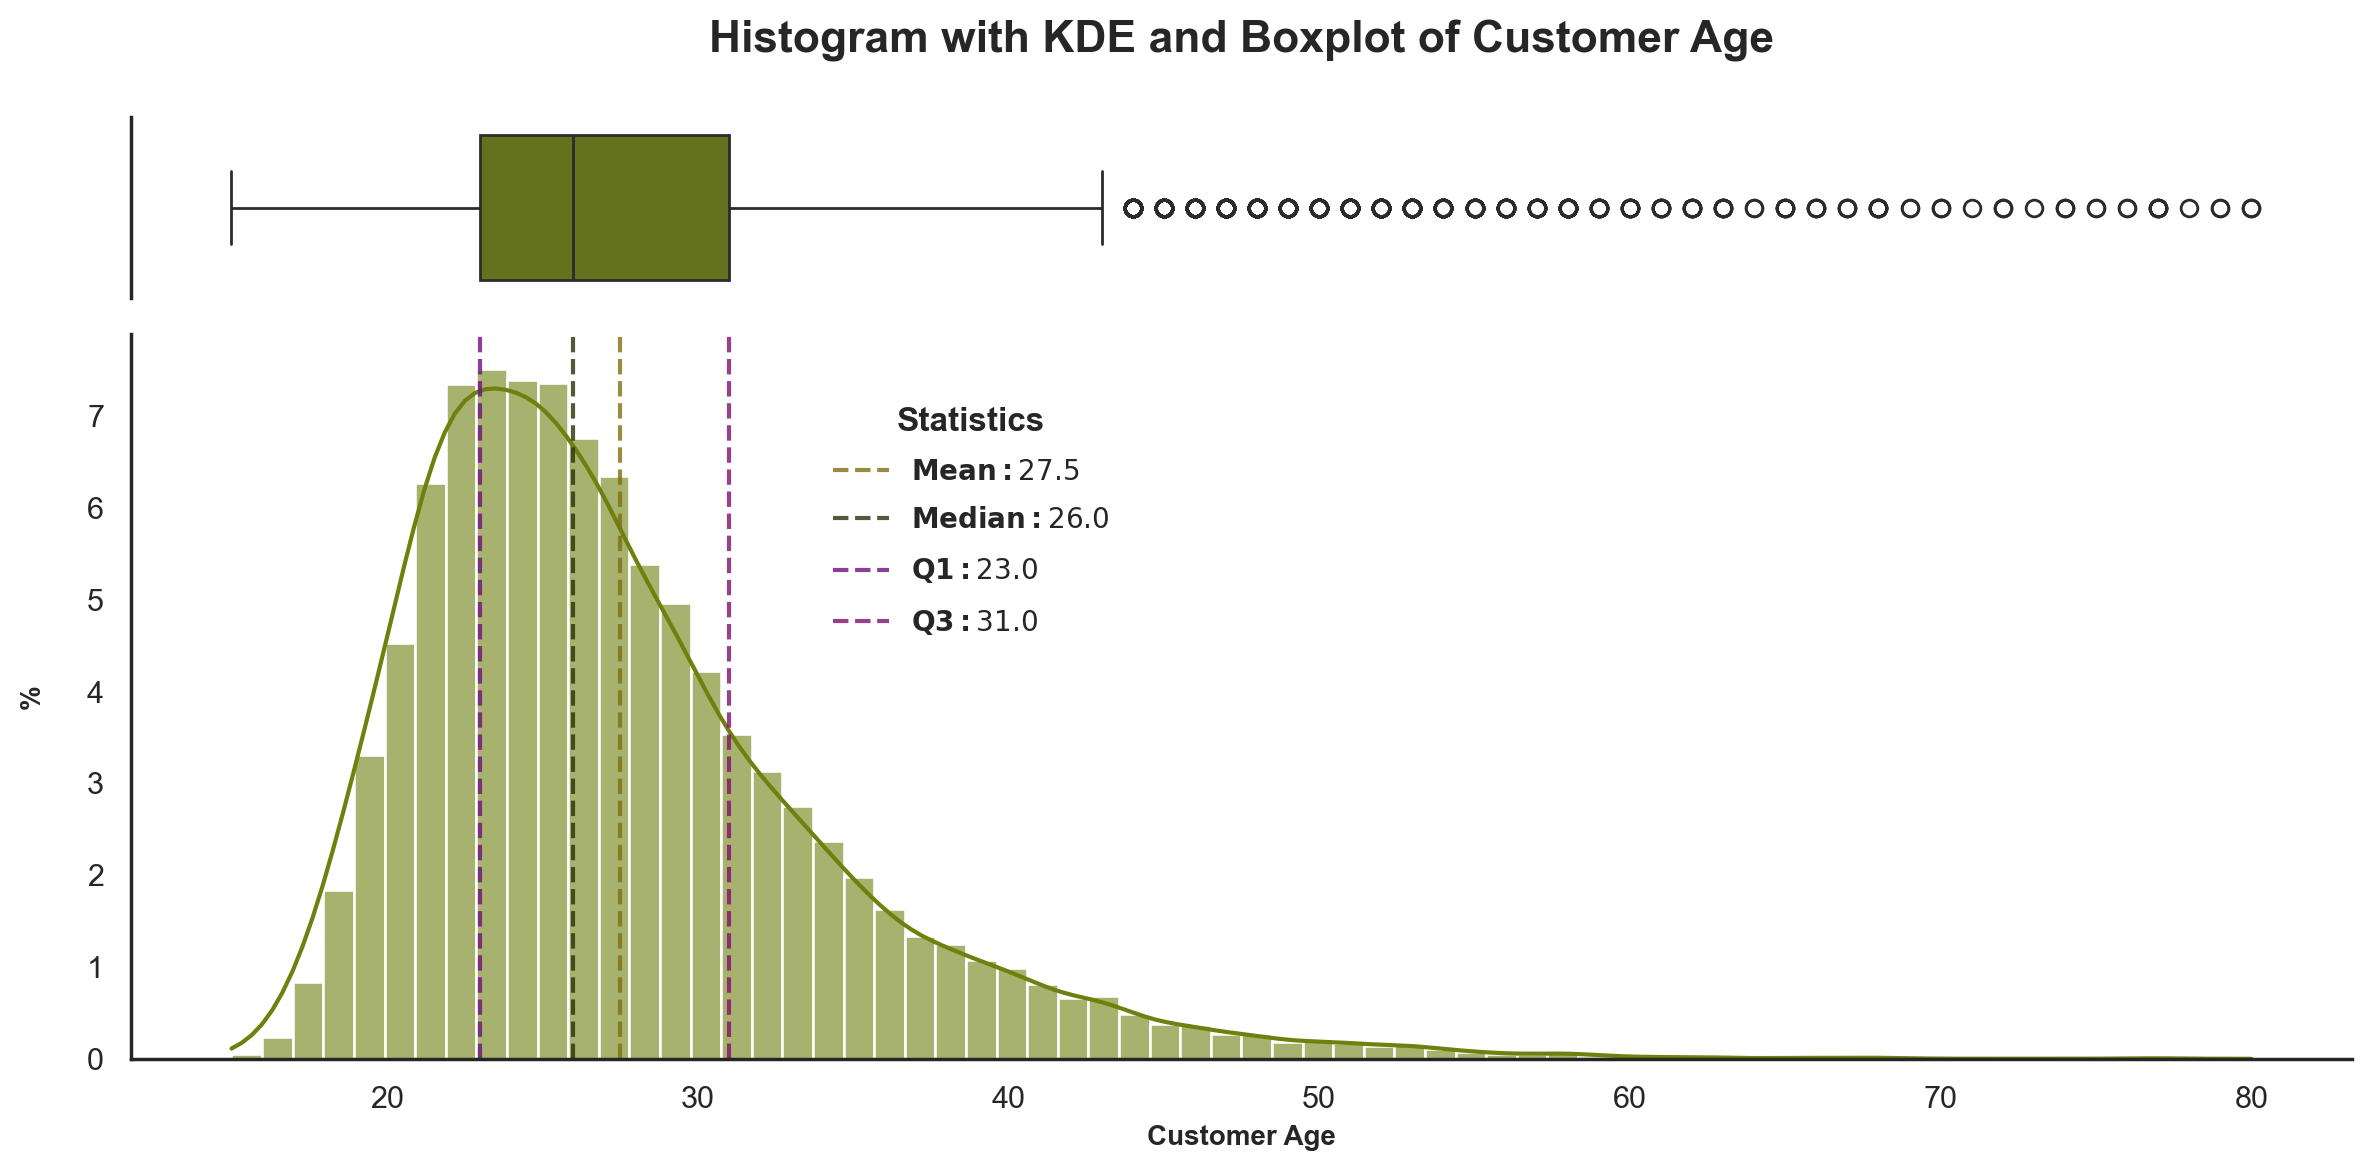

In [45]:
# Histogram of the column 'customer_age' with Kernel Density Estimate (KDE) and BoxPlot on top of the histogram [After Imputation]

# Create a plot with 2 axes (one for the histogram and one for the boxplot)
fig, (ax_box, ax_hist) = plt.subplots(2,                                               # 2 rows
                                      sharex=True,                                     # Share the x-axis
                                      gridspec_kw={"height_ratios": (.20, .80)},       # Set the height ratios
                                      figsize=(12, 6))                                 # Set the figure size

# Plot the Boxplot on the top
sns.boxplot(ABCDEats['customer_age'], color='#6f800f', orient='h', ax=ax_box)

# Plot the Histogram and the KDE on the bottom
sns.histplot(ABCDEats['customer_age'], bins=ABCDEats['customer_age'].nunique(), color='#6f800f', alpha=0.6, stat='percent', kde=True, ax=ax_hist)

# Add title and labels
ax_box.set_title('Histogram with KDE and Boxplot of Customer Age\n', fontweight='bold', fontsize=16)
ax_box.set(xlabel='')
ax_hist.set_xlabel('Customer Age', fontweight='bold', fontsize=10)
ax_hist.set_ylabel('%\n', fontweight='bold', fontsize=10)

# Add mean, median and percentiles to the plot
mean_age = ABCDEats['customer_age'].mean()
median_age = ABCDEats['customer_age'].median()
q1_age = ABCDEats['customer_age'].quantile(0.25)
q3_age = ABCDEats['customer_age'].quantile(0.75)

plt.axvline(mean_age, color='#806F0F', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Mean:}} {mean_age:.1f}$')
plt.axvline(median_age, color='#2A3006', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Median:}} {median_age:.1f}$')
plt.axvline(q1_age, color='#6F0F80', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q1:}} {q1_age:.1f}$')
plt.axvline(q3_age, color='#800F6F', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q3:}} {q3_age:.1f}$')

plt.legend(fontsize=10, title='Statistics', title_fontproperties={'weight':'bold', 'size':'12'},
           labelspacing=0.8, borderpad=0.8, frameon=False, bbox_to_anchor=(.3, 0.95))

sns.despine(top=True, right=True, ax=ax_hist)
sns.despine(top=True, right=True, bottom=True, ax=ax_box)
plt.tight_layout()
fig.savefig('./EDA_Outputs/Histogram_KDE_Boxplot_Customer_Age.png', dpi=300, bbox_inches='tight')
plt.show()

> Comparison distribution of **`customer_age`** before and after imputation we can see that the distribution is equal!

In [46]:
# Impute the missing values in the 'customer_age_group' column with the 'customer_age' column after imputation
ABCDEats['customer_age_group'] = pd.cut(ABCDEats['customer_age'], bins=[14, 28, 41, 54, 67, 80], labels=['15-28', '29-41', '42-54', '55-67', '68-80'])

# Check the variable 'customer_age_group' - Absolute and Relative Frequency Table
customer_age_group_n_freq = ABCDEats['customer_age_group'].value_counts().reset_index()
customer_age_group_n_freq.columns = ['customer_age_group', 'n']
customer_age_group_n_freq['%'] = round(customer_age_group_n_freq['n'] / ABCDEats.shape[0] * 100, 2)
customer_age_group_n_freq.set_index('customer_age_group', inplace=True)
pd.DataFrame(customer_age_group_n_freq.sort_values(by='n', ascending=False))

,n,%
customer_age_group,,
15-28,20677,65.15
29-41,9551,30.09
42-54,1323,4.17
55-67,149,0.47
68-80,37,0.12


In [47]:
# Confirm that sum of '%' column is 100
round(customer_age_group_n_freq['%'].sum(), 1)

100.0

In [48]:
# Confirm that ABCDEats has no missing values
print(f'Number of missing values in ABCDEats: {ABCDEats.isnull().sum().sum()}')

Number of missing values in ABCDEats: 0


---

### 🏮 **Outliers** <a class='anchor' id='DP_Outliers'></a> 

In [49]:
# Define function for outlier detection, based on IQR method
def detect_outliers(df,features, dfoutput=False, info=True):
    """
    Detect outliers in the DataFrame based on the InterQuartile Range (IQR) method.

    Args:
        df (pd.DataFrame): The DataFrame to detect the outliers.
        features (list): The list of features to detect the outliers.
        dfoutput (bool, optional): Boolean to return the DataFrame with the outliers. Defaults to False.
        info (bool, optional): Boolean to print the information about the outliers. Defaults to True.

    Returns:
        pd.DataFrame: DataFrame with the outliers (if dfoutput=True).
        pd.DataFrame: Information about the outliers (if info=True and dfoutput=False or info=True and dfoutput=True).
    """
    # Check if features is a list
    if not isinstance(features, list):
        features = [features]
    
    if len(features) == 0:
        return []
    
    # Detect outliers in 1 features
    for feature in features:
        Q1 = df[feature].quantile(0.25)       # 1st quartile
        Q3 = df[feature].quantile(0.75)       # 3rd quartile
        IQR = Q3 - Q1                         # InterQuartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        
        # Print the information about the outliers
        if info:
            # print('\033[1m', feature, '\033[0m',
            #         '\n  1st Quartile:', Q1, '  | 3rd Quartile:', Q3, '  | IQR:', IQR,
            #         '\n  Lower Bound:', lower_bound, '  | Upper Bound:', upper_bound,
            #         '\n\n  Number of outliers:', len(outliers), '(', round(len(outliers)/len(df)*100, 2), '%)',
            #         '\n    Min:', outliers[feature].min(), '  | Max:', outliers[feature].max(), '\n')
            
            # Save the information that are printed in a DataFrame format
            outliers_info = pd.DataFrame({
                'Feature': feature,
                '1st Quartile': Q1,
                '3rd Quartile': Q3,
                'IQR': IQR,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound,
                'Number of Outliers': len(outliers),
                'Percentage of Outliers (%)': round(len(outliers)/len(df)*100, 2),
                'Min': outliers[feature].min(),
                'Max': outliers[feature].max()
            }, index=[0])
            
            # Return the DataFrame with the information about the outliers
            return outliers_info
            
        # Return DataFrame with the outliers and the information about the outliers
        if dfoutput:
            return outliers_info, outliers

In [50]:
# Apply the function 'detect_outliers' to all the metric columns
for col in metric_cols:  
    # If it is the first column, save the information about the outliers
    if col == metric_cols[0]:
        outliers_info = detect_outliers(ABCDEats, col, info=True)
    else:
        # Combine the information about the outliers of all the columns in a single DataFrame
        outliers_info = pd.concat([outliers_info, detect_outliers(ABCDEats, col, info=True)], ignore_index=True)
    
    
outliers_info.set_index('Feature', inplace=True)

# Personalize the DataFrame with a grey color for the rows without outliers
def highlight_no_outliers(row):
    # Check if the "Number of Outliers" column is zero
    if row['Number of Outliers'] == 0:
        return ['background-color: #ECEDDF'] * len(row)
    return [''] * len(row)

# Apply styling to the DataFrame
outliers_info.style.format({
    col: '{:.2f}' for col in outliers_info.select_dtypes('float64').columns
}).apply(highlight_no_outliers, axis=1)

,1st Quartile,3rd Quartile,IQR,Lower Bound,Upper Bound,Number of Outliers,Percentage of Outliers (%),Min,Max
Feature,,,,,,,,,
customer_age,23.00,31.00,8.00,11.00,43.00,1078,3.40,44.00,80.00
vendor_count,1.00,4.00,3.00,-3.50,8.50,1523,4.80,9.00,41.00
product_count,2.00,7.00,5.00,-5.50,14.50,2370,7.47,15.00,269.00
is_chain,1.00,3.00,2.00,-2.00,6.00,3154,9.94,7.00,83.00
first_order,7.00,44.00,37.00,-48.50,99.50,0,0.00,nan,nan
last_order,49.00,83.00,34.00,-2.00,134.00,0,0.00,nan,nan
CUI_American,0.00,5.71,5.71,-8.56,14.27,3482,10.97,14.29,280.21
CUI_Asian,0.00,11.86,11.86,-17.79,29.65,3462,10.91,29.66,896.71
CUI_Beverages,0.00,0.00,0.00,0.00,0.00,5431,17.11,0.32,229.22


<div class="alert alert-block alert-danger" style="font-size: 35px; font-weight: bold;">
    <b>🚨 Attention:</b> Ignorar AGE!
</div>    

In [51]:
# Compute the IQR

# Calculate Q1, Q3, IQR
q25 = ABCDEats[metric_cols].quantile(.25)
q75 = ABCDEats[metric_cols].quantile(.75)
iqr = (q75 - q25)

# Compute upper and lower limit 
# lower_limit = Q1 -1.5*IQR
upper_lim = q75 + 1.5 * iqr

# upper_limit = Q3 + 1.5*IQR
lower_lim = q25 - 1.5 * iqr

filters_iqr = []
for metric in set(metric_cols) - set(cuisines_cols) - set(weekdays) - set(hours_cols):        ################# MAL FEITO
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_iqr.append(ABCDEats[metric].between(llim, ulim, inclusive='neither'))

filters_iqr_all = np.all(filters_iqr, axis=0)

df_iqr = ABCDEats[filters_iqr_all]
print('....', filters_iqr_all.sum())
print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / ABCDEats.shape[0], 4)))

.... 22995
Percentage of data kept after removing outliers: 72.45


> **[NOTE:]** If we use the outlier removal method based only on the IQR, we cannot retain any data.

In [52]:
filters_iqr_all

array([ True,  True,  True, ...,  True,  True,  True])

In [53]:
filters_man = (
    #   ( df['feature1']<= limit1 ) 
    # & ( df['feature2']<= limit2 )
    # ...
    (ABCDEats['customer_age']<=65)
    &
    (ABCDEats['product_count']<=100)
    &
    (ABCDEats['vendor_count']<=30)
    &
    (ABCDEats['is_chain']<=50)
    &
    (ABCDEats['order_count']<=60)
    &
    (ABCDEats['CUI_American']<= 150)
    &
    (ABCDEats['CUI_Asian']<= 400)
    &
    (ABCDEats['CUI_Beverages']<= 150)
    &
    (ABCDEats['CUI_Cafe']<= 150)
    &
    (ABCDEats['CUI_Chicken Dishes']<= 75)
    &
    (ABCDEats['CUI_Chinese']<= 200)
    &
    (ABCDEats['CUI_Desserts']<= 100)
    &
    (ABCDEats['CUI_Healthy']<= 150)
    &
    (ABCDEats['CUI_Indian']<= 150)
    &
    (ABCDEats['CUI_Italian']<= 200)
    &
    (ABCDEats['CUI_Japanese']<= 180)
    &
    (ABCDEats['CUI_Noodle Dishes']<= 190)
    &
    (ABCDEats['CUI_OTHER']<= 150)
    &
    (ABCDEats['CUI_Street Food / Snacks']<= 200)
    &
    (ABCDEats['CUI_Thai']<= 60)
)

df_man = ABCDEats[filters_man]
print('Percentage of data kept after removing outliers:', 100*np.round(df_man.shape[0] / ABCDEats.shape[0], 4))

Percentage of data kept after removing outliers: 99.4


In [54]:
# Combining different outlier methods
# More robust/ consistent outlier detection method:
df_out = ABCDEats[(filters_iqr_all | filters_man)] 
print('Percentage of data kept after removing outliers:', 100*np.round(df_out.shape[0] / ABCDEats.shape[0], 4))

Percentage of data kept after removing outliers: 99.42


In [55]:
# Get the manual filtering version
ABCDEats = df_man.copy()

In [56]:
# Drop the rows with outliers
# ABCDEats = ABCDEats[filters_iqr_all]

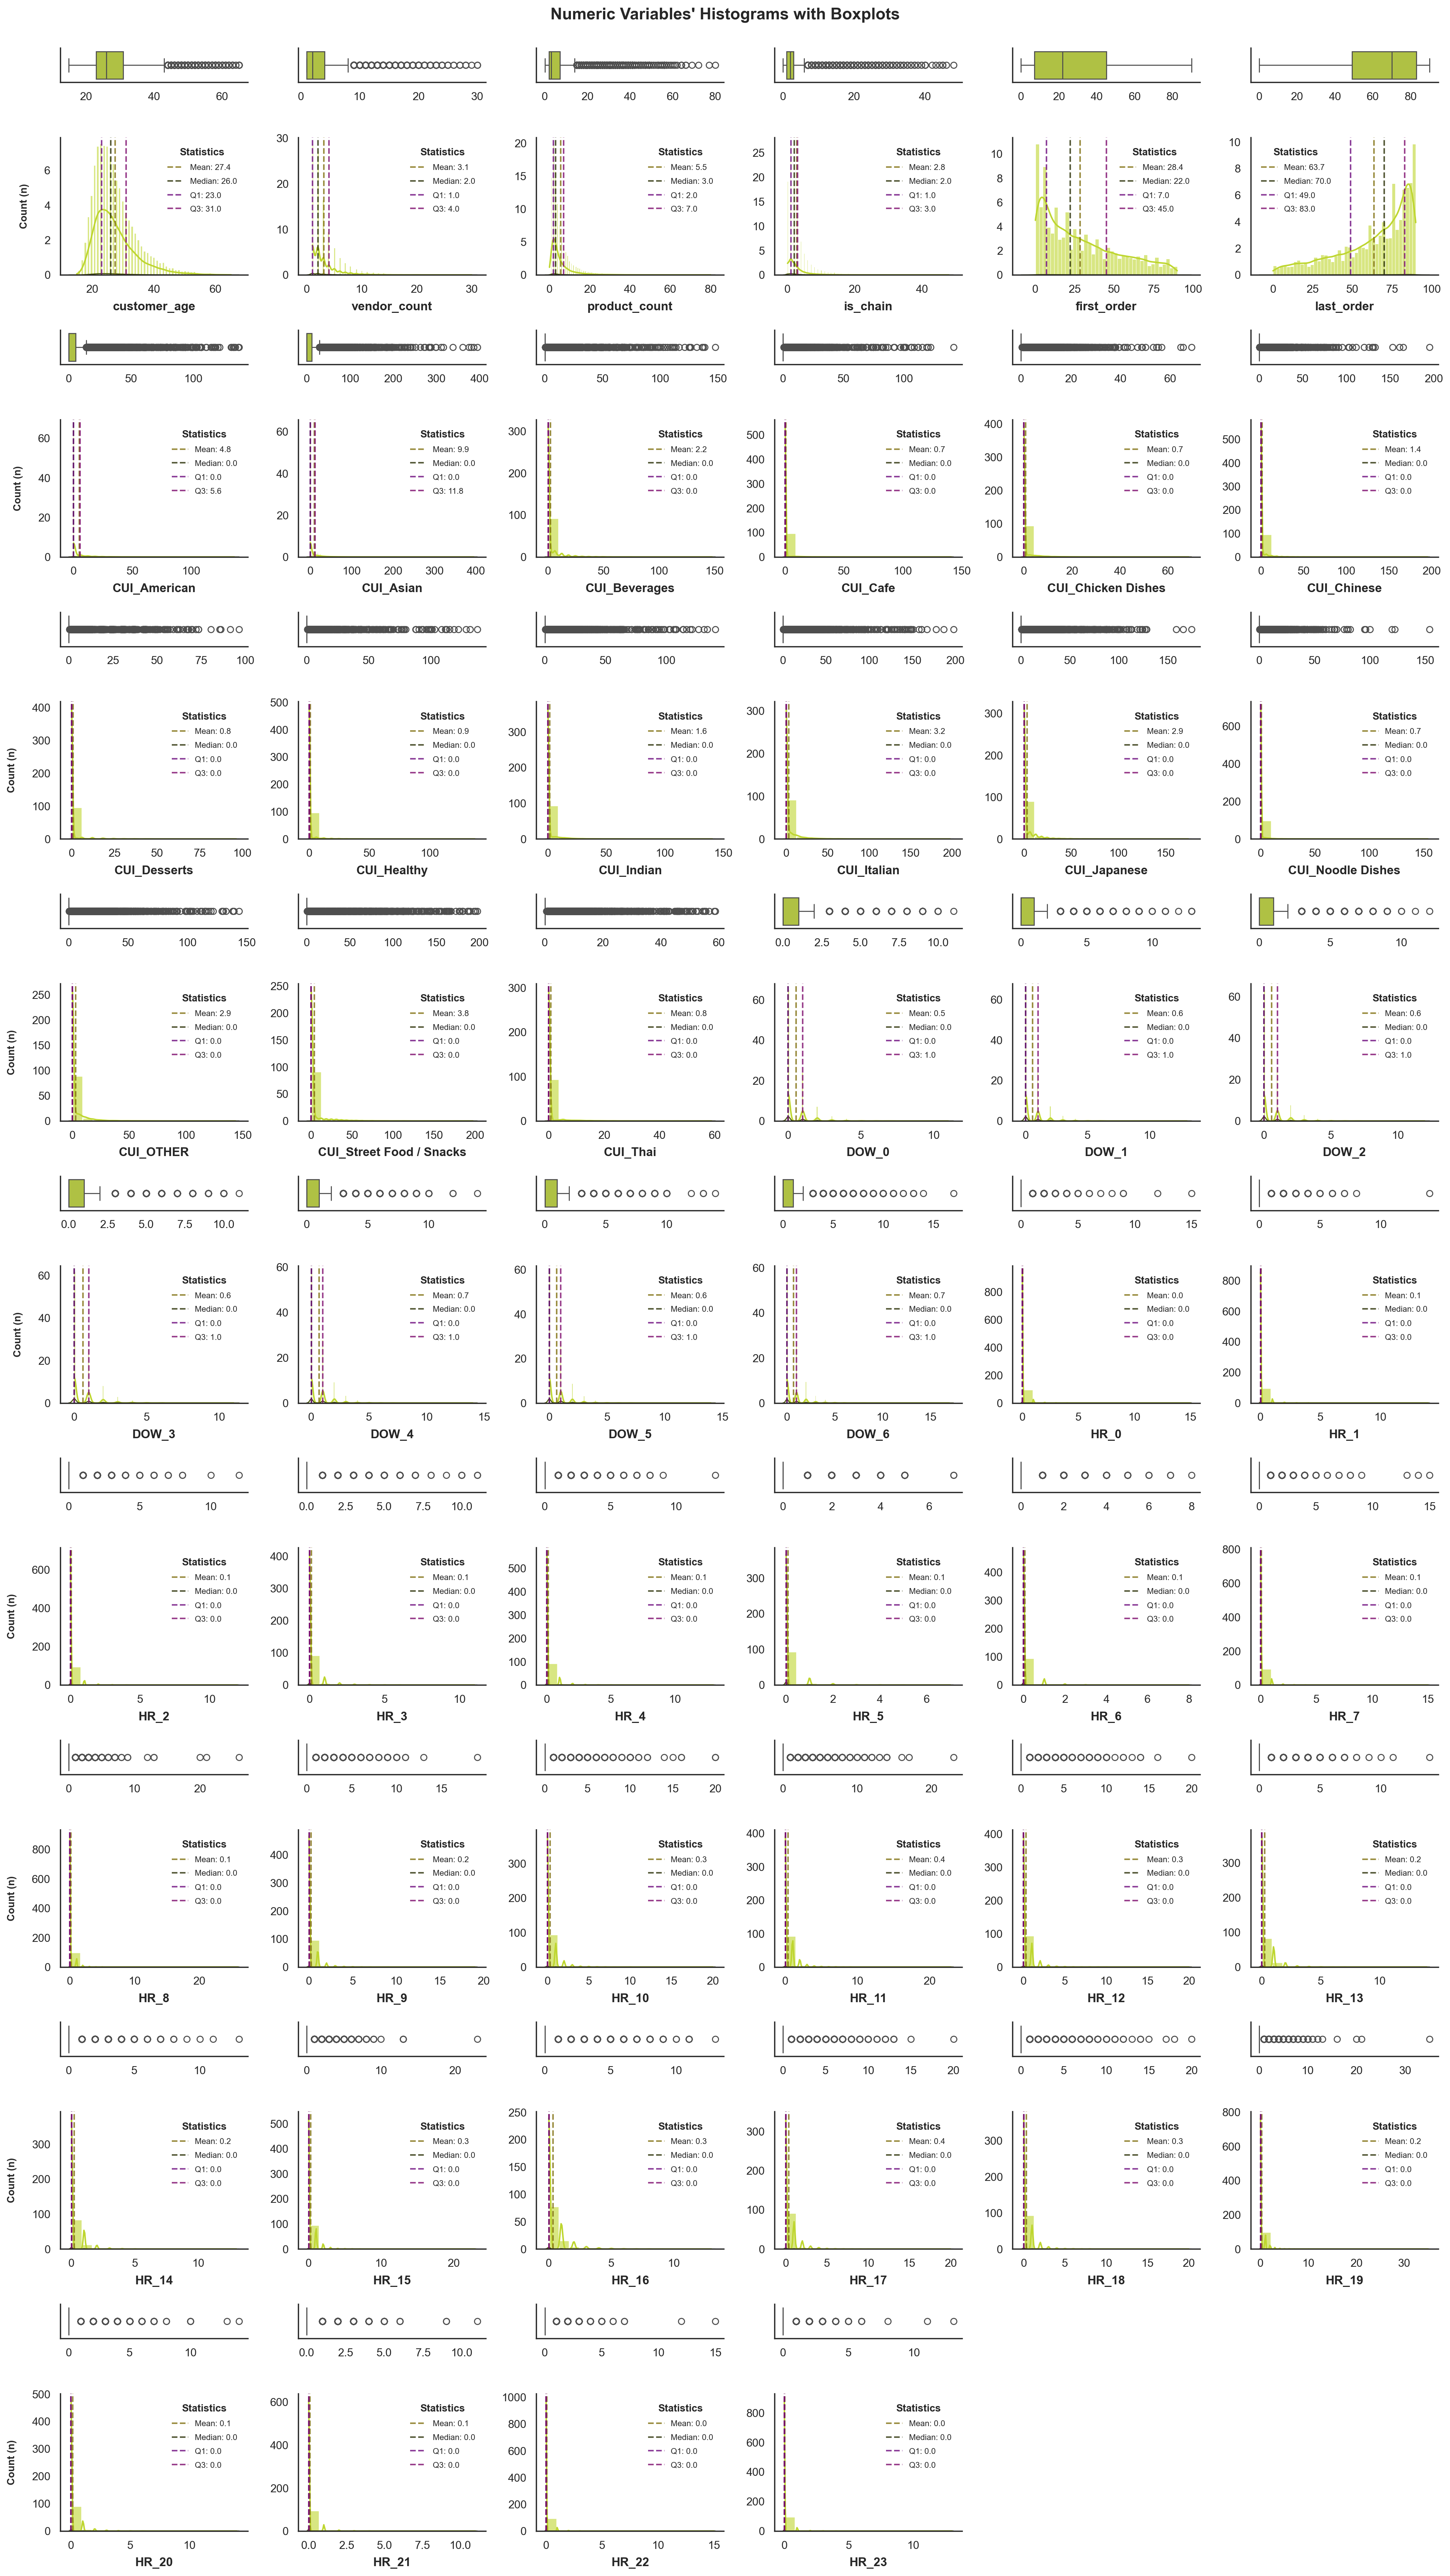

In [57]:
# Plot ALL Numeric Variables' Histograms with Boxplots [After Imputation]
sp_rows = 9
sp_cols = 6

# Prepare figure. Create individual axes where each histogram and boxplot will be placed
fig, axes = plt.subplots(sp_rows * 2, sp_cols,                                        # Create subplots
                         figsize=(20, 4*sp_rows),                                     # Set the figure size
                         tight_layout=True,                                           # Automatically adjust subplot parameters to give specified padding
                         gridspec_kw={'height_ratios': [0.2, 0.8] * sp_rows})         # Set the height ratios of the subplots

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.5)  # Increase the vertical space between subplots

# Plot data
# Iterate across axes objects and associate each histogram and boxplot
for i, (ax_box, ax_hist, feat) in enumerate(zip(axes[::2].flatten(), axes[1::2].flatten(), metric_cols)):

    # Plot the Boxplot on the top
    sns.boxplot(ABCDEats[feat], color='#bEd62f', orient='h', ax=ax_box)
    
    # Plot the Histogram and the KDE on the bottom
    sns.histplot(ABCDEats[feat], color='#bEd62f', kde=True, stat='percent', alpha=0.6, ax=ax_hist)
    sns.kdeplot(ABCDEats[feat], color='#47520A', lw=1, warn_singular=False, ax=ax_hist)
    
    # Add mean, median and percentiles to the plot
    mean_val = ABCDEats[feat].mean()
    median_val = ABCDEats[feat].median()
    q1_val = ABCDEats[feat].quantile(0.25)
    q3_val = ABCDEats[feat].quantile(0.75)
    
    ax_hist.axvline(mean_val, color='#806F0F', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Mean: {mean_val:.1f}')
    ax_hist.axvline(median_val, color='#2A3006', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Median: {median_val:.1f}')
    ax_hist.axvline(q1_val, color='#6F0F80', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q1: {q1_val:.1f}')
    ax_hist.axvline(q3_val, color='#800F6F', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q3: {q3_val:.1f}')

    # Add a legend to the histogram
    ax_hist.legend(loc='best',          # Position of the legend (automatic placement to avoid overlapping)
                   title='Statistics',  # Title of the legend 
                   title_fontproperties={'weight':'bold',  # Title font weight
                                         'size':'10'},     # Title font size
                   fontsize=8,          # Legend font size
                   labelspacing=0.8,    # Spacing between the legend handles and labels
                   borderpad=0.8,       # Border pad around the legend
                   frameon=False)       # Whether to draw a frame around the legend
    
    # Customizing the titles and labels of the plots
    ax_box.set_xlabel(None)
    ax_box.set_ylabel(None)
    ax_hist.set_title(feat, y=-0.30, fontweight='bold')
    ax_hist.set_xlabel(None)
    ax_hist.set_ylabel(None)
    
    # Add y-label 'Count' to the first plots on the left
    if i % sp_cols == 0:
        ax_hist.set_ylabel('Count (n)\n', fontsize=10, fontweight='bold')
    
    # Remove the top and right spines for a cleaner look
    sns.despine(ax=ax_box, top=True, right=True)
    sns.despine(ax=ax_hist, top=True, right=True)

# Remove any unused subplots (empty subplots)
axes.flatten()[-1].set_visible(False)
axes.flatten()[-2].set_visible(False)
axes.flatten()[-sp_cols-1].set_visible(False)
axes.flatten()[-sp_cols-2].set_visible(False)

# Layout
# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms with Boxplots\n\n\n", fontweight='bold', fontsize=16)
fig.savefig('./Preprocessing_Outputs/Numeric_Variables_Histograms_Boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

---

### **PCA (Principal Component Analysis)**

In [78]:
early_orders_0_6 = ABCDEats[(ABCDEats['HR_0'] != 0) | (ABCDEats['HR_1'] != 0) | 
                             (ABCDEats['HR_2'] != 0) | (ABCDEats['HR_3'] != 0) | 
                             (ABCDEats['HR_4'] != 0) | (ABCDEats['HR_5'] != 0) | 
                             (ABCDEats['HR_6'] != 0)]

no_early_orders_0_6 = ABCDEats[(ABCDEats['HR_0'] == 0) & (ABCDEats['HR_1'] == 0) & 
                                (ABCDEats['HR_2'] == 0) & (ABCDEats['HR_3'] == 0) & 
                                (ABCDEats['HR_4'] == 0) & (ABCDEats['HR_5'] == 0) & 
                                (ABCDEats['HR_6'] == 0)]

early_orders_7_11 = ABCDEats[(ABCDEats['HR_7'] != 0) | (ABCDEats['HR_8'] != 0) | 
                              (ABCDEats['HR_9'] != 0) | (ABCDEats['HR_10'] != 0) | 
                              (ABCDEats['HR_11'] != 0)]

no_early_orders_7_11 = ABCDEats[(ABCDEats['HR_7'] == 0) & (ABCDEats['HR_8'] == 0) & 
                                 (ABCDEats['HR_9'] == 0) & (ABCDEats['HR_10'] == 0) & 
                                 (ABCDEats['HR_11'] == 0)]

early_orders_12_15 = ABCDEats[(ABCDEats['HR_12'] != 0) | (ABCDEats['HR_13'] != 0) |  
                               (ABCDEats['HR_14'] != 0) | (ABCDEats['HR_15'] != 0)]

no_early_orders_12_15 = ABCDEats[(ABCDEats['HR_12'] == 0) & (ABCDEats['HR_13'] == 0) &  
                                  (ABCDEats['HR_14'] == 0) & (ABCDEats['HR_15'] == 0)]

early_orders_16_18 = ABCDEats[(ABCDEats['HR_16'] != 0) | (ABCDEats['HR_17'] != 0) |  
                               (ABCDEats['HR_18'] != 0)]

no_early_orders_16_18 = ABCDEats[(ABCDEats['HR_16'] == 0) & (ABCDEats['HR_17'] == 0) &  
                                  (ABCDEats['HR_18'] == 0)]

early_orders_19_21 = ABCDEats[(ABCDEats['HR_19'] != 0) | (ABCDEats['HR_20'] != 0) |  
                               (ABCDEats['HR_21'] != 0)]

no_early_orders_19_21 = ABCDEats[(ABCDEats['HR_19'] == 0) & (ABCDEats['HR_20'] == 0) &  
                                  (ABCDEats['HR_21'] == 0)]

early_orders_22_23 = ABCDEats[(ABCDEats['HR_22'] != 0) | (ABCDEats['HR_23'] != 0)]

no_early_orders_22_23 = ABCDEats[(ABCDEats['HR_22'] == 0) & (ABCDEats['HR_23'] == 0)]

mean_early_orders_0_6 = early_orders_0_6.mean(numeric_only=True)
mean_no_early_orders_0_6 = no_early_orders_0_6.mean(numeric_only=True)

mean_early_orders_7_11 = early_orders_7_11.mean(numeric_only=True)
mean_no_early_orders_7_11 = no_early_orders_7_11.mean(numeric_only=True)

mean_early_orders_12_15 = early_orders_12_15.mean(numeric_only=True)
mean_no_early_orders_12_15 = no_early_orders_12_15.mean(numeric_only=True)

mean_early_orders_16_18 = early_orders_16_18.mean(numeric_only=True)
mean_no_early_orders_16_18 = no_early_orders_16_18.mean(numeric_only=True)

mean_early_orders_19_21 = early_orders_19_21.mean(numeric_only=True)
mean_no_early_orders_19_21 = no_early_orders_19_21.mean(numeric_only=True)

mean_early_orders_22_23 = early_orders_22_23.mean(numeric_only=True)
mean_no_early_orders_22_23 = no_early_orders_22_23.mean(numeric_only=True)

mean_all = ABCDEats.mean(numeric_only=True)

comparison = pd.DataFrame({
    "Mean_All": mean_all,
    "Mean_Early_Orders_0_6": mean_early_orders_0_6,
    "Mean_No_Early_Orders_0_6": mean_no_early_orders_0_6,
    "Mean_Early_Orders_7_11": mean_early_orders_7_11,
    "Mean_No_Early_Orders_7_11": mean_no_early_orders_7_11,
    "Mean_Early_Orders_12_15": mean_early_orders_12_15,
    "Mean_No_Early_Orders_12_15": mean_no_early_orders_12_15,
    "Mean_Early_Orders_16_18": mean_early_orders_16_18,
    "Mean_No_Early_Orders_16_18": mean_no_early_orders_16_18,
    "Mean_Early_Orders_19_21": mean_early_orders_19_21,
    "Mean_No_Early_Orders_19_21": mean_no_early_orders_19_21,
    "Mean_Early_Orders_22_23": mean_early_orders_22_23,
    "Mean_No_Early_Orders_22_23": mean_no_early_orders_22_23
})

# comparison

In [59]:
ABCDEats_standard = ABCDEats.copy()

In [60]:
ss_scaler = StandardScaler() # finish this line
ss_scaled_feat = ss_scaler.fit_transform(ABCDEats[metric_cols]) # finish this line
ss_scaled_feat

array([[-1.3696166 , -0.40557843, -0.08413836, ..., -0.20292637,
        -0.87010446,  0.52928233],
       [-1.51457494, -0.40557843, -0.57830108, ..., -0.43800854,
        -0.18737382, -0.08721411],
       [ 1.52955003, -0.7796074 , -0.57830108, ..., -0.68135626,
        -0.87010446, -0.72538675],
       ...,
       [-0.49986661, -0.7796074 , -0.74302199, ..., -0.47252939,
        -0.87010446,  0.95643084],
       [ 0.9497167 , -0.7796074 , -0.74302199, ..., -0.61255766,
        -0.87010446,  0.22199041],
       [ 0.36988337, -0.7796074 , -0.74302199, ..., -0.71271676,
        -0.87010446, -0.30333851]])

In [61]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n")
pd.DataFrame([ss_scaler.mean_, np.sqrt(ss_scaler.var_)], columns=metric_cols, index=['mean','std'])

Parameters fitted:



,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
mean,27.45,3.08,5.51,2.75,28.40,63.65,4.78,9.86,2.23,0.71,0.74,1.37,0.84,0.92,1.58,3.16,2.92,0.69,2.88,3.76,0.77,0.54,0.55,0.58,0.60,0.66,0.64,0.69,0.05,0.05,0.06,0.12,0.10,0.08,0.07,0.07,0.13,0.23,0.32,0.37,0.31,0.23,0.21,0.27,0.35,0.38,0.33,0.24,0.14,0.07,0.05,0.04,4.27,35.25,8.50,37.23,2.27,10.29
std,6.90,2.67,6.07,3.60,24.08,23.19,10.95,22.51,7.82,4.99,3.10,6.20,4.49,5.30,6.77,10.34,8.90,4.08,8.62,14.05,3.66,0.96,0.98,0.98,1.01,1.03,1.02,1.12,0.30,0.31,0.33,0.49,0.42,0.35,0.32,0.36,0.52,0.68,0.83,0.89,0.80,0.61,0.58,0.71,0.83,0.90,0.87,0.77,0.52,0.34,0.29,0.28,4.55,29.32,7.90,41.13,1.46,7.84


In [62]:
ABCDEats_standard[metric_cols] = ss_scaled_feat
ABCDEats_standard.head()

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,-1.37,-0.41,-0.08,-0.49,-1.18,-2.70,DELIVERY,DIGI,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,4.03,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,1.93,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,2,15-28,-1.17,-1.01,True,-0.20,Indian,-0.87,0.53
1,5d272b9dcb,8670,-1.51,-0.41,-0.58,-0.21,-1.18,-2.70,DISCOUNT,DIGI,0.73,-0.15,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,0.82,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,8,15-28,-1.17,-1.01,True,-0.44,American,-0.19,-0.09
2,f6d1b2ba63,4660,1.53,-0.78,-0.58,-0.21,-1.18,-2.70,DISCOUNT,CASH,0.40,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,1.13,-0.38,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,29-41,-1.17,-1.01,True,-0.68,American,-0.87,-0.73
3,180c632ed8,4660,-0.50,-0.41,-0.41,-0.49,-1.18,-2.66,DELIVERY,DIGI,-0.44,0.17,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,2.40,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,0.71,-0.38,-0.38,1.37,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,15-28,-1.13,-0.95,True,-0.14,Indian,-0.19,0.70
4,4eb37a6705,4660,-1.08,-0.41,-0.08,-0.76,-1.18,-2.66,NO PROMO,DIGI,0.89,1.38,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,1.67,1.13,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,15-28,-1.13,-0.95,False,0.44,Asian,-0.19,2.22


In [63]:
# Checking mean and variance of standardized variables
ABCDEats_standard[metric_cols].describe().round(2)

Variables,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
count,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00,31547.00
mean,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.80,-0.78,-0.91,-0.76,-1.18,-2.75,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,-0.62,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.72,-1.20,-1.08,-0.90,-0.87,-1.26
25%,-0.64,-0.78,-0.58,-0.49,-0.89,-0.63,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,-0.62,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.10,-0.91,-0.59,-0.87,-0.67
50%,-0.21,-0.41,-0.41,-0.21,-0.27,0.27,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,-0.62,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.28,-0.04,-0.17,-0.32,-0.19,-0.27
75%,0.51,0.34,0.25,0.07,0.69,0.83,0.08,0.09,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,0.46,0.43,0.39,0.33,0.35,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,0.16,0.88,0.54,0.18,0.50,0.33
max,5.44,10.07,12.27,12.55,2.56,1.14,12.03,17.08,18.59,28.14,21.86,31.28,21.28,25.76,20.51,18.84,19.24,37.59,16.31,13.79,15.86,10.93,12.74,11.64,10.32,12.93,13.07,14.57,49.32,44.83,35.91,22.07,30.39,19.56,24.57,41.16,49.30,27.52,23.76,25.47,24.60,22.54,22.13,32.14,15.15,21.73,22.73,45.29,26.44,32.34,51.15,46.19,12.24,1.87,4.56,13.83,6.64,11.99


In [64]:
df_pca = ABCDEats_standard.copy()

In [65]:
# Check NAs
ABCDEats_standard.isna().sum().sum()

0

In [66]:
cuisines_cols

['CUI_American',
 'CUI_Asian',
 'CUI_Beverages',
 'CUI_Cafe',
 'CUI_Chicken Dishes',
 'CUI_Chinese',
 'CUI_Desserts',
 'CUI_Healthy',
 'CUI_Indian',
 'CUI_Italian',
 'CUI_Japanese',
 'CUI_Noodle Dishes',
 'CUI_OTHER',
 'CUI_Street Food / Snacks',
 'CUI_Thai',
 'CUI_Total_Amount_Spent',
 'CUI_Most_Spent_Cuisine',
 'CUI_Total_Food_Types',
 'CUI_Avg_Amount_Spent']

In [67]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality of data
pca = PCA()
cuisines_cols_excluded_cols = ['CUI_Total_Amount_Spent', 'CUI_Most_Spent_Cuisine', 'CUI_Total_Food_Types', 'CUI_Avg_Amount_Spent']
cuisines_cols_selected_cols = [col for col in cuisines_cols if col not in cuisines_cols_excluded_cols]
pca_feat = pca.fit_transform(df_pca[cuisines_cols_selected_cols])
pca_feat

array([[ 0.91128823, -0.56034548, -0.71381553, ..., -0.1136539 ,
        -0.46541253, -0.22116495],
       [-0.21165334, -0.23553705, -0.51929748, ..., -0.5579811 ,
        -0.13821222, -0.23435758],
       [-0.14099208, -0.49245489, -0.53484226, ..., -0.4408138 ,
        -0.15437111, -0.35068476],
       ...,
       [-1.25477096,  0.17657064,  0.22410119, ..., -0.64355954,
        -0.10913297, -0.45591495],
       [-0.38334652, -0.61116494, -0.42540207, ..., -0.34606983,
         0.09821911,  0.27245754],
       [ 0.05271195, -0.71014959, -0.69978591, ...,  0.22275443,
        -0.07073676,  0.11238219]])

In [68]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_ 

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_ 

# get the cumulative explained variance ratio 
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)          

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

,Eigenvalue,Difference,Proportion,Cumulative
1,1.58,0.00,0.11,0.11
2,1.39,-0.19,0.09,0.20
3,1.26,-0.13,0.08,0.28
4,1.01,-0.25,0.07,0.35
5,0.98,-0.03,0.07,0.41
6,0.96,-0.02,0.06,0.48
7,0.93,-0.03,0.06,0.54
8,0.91,-0.02,0.06,0.60
9,0.91,-0.00,0.06,0.66
10,0.89,-0.01,0.06,0.72


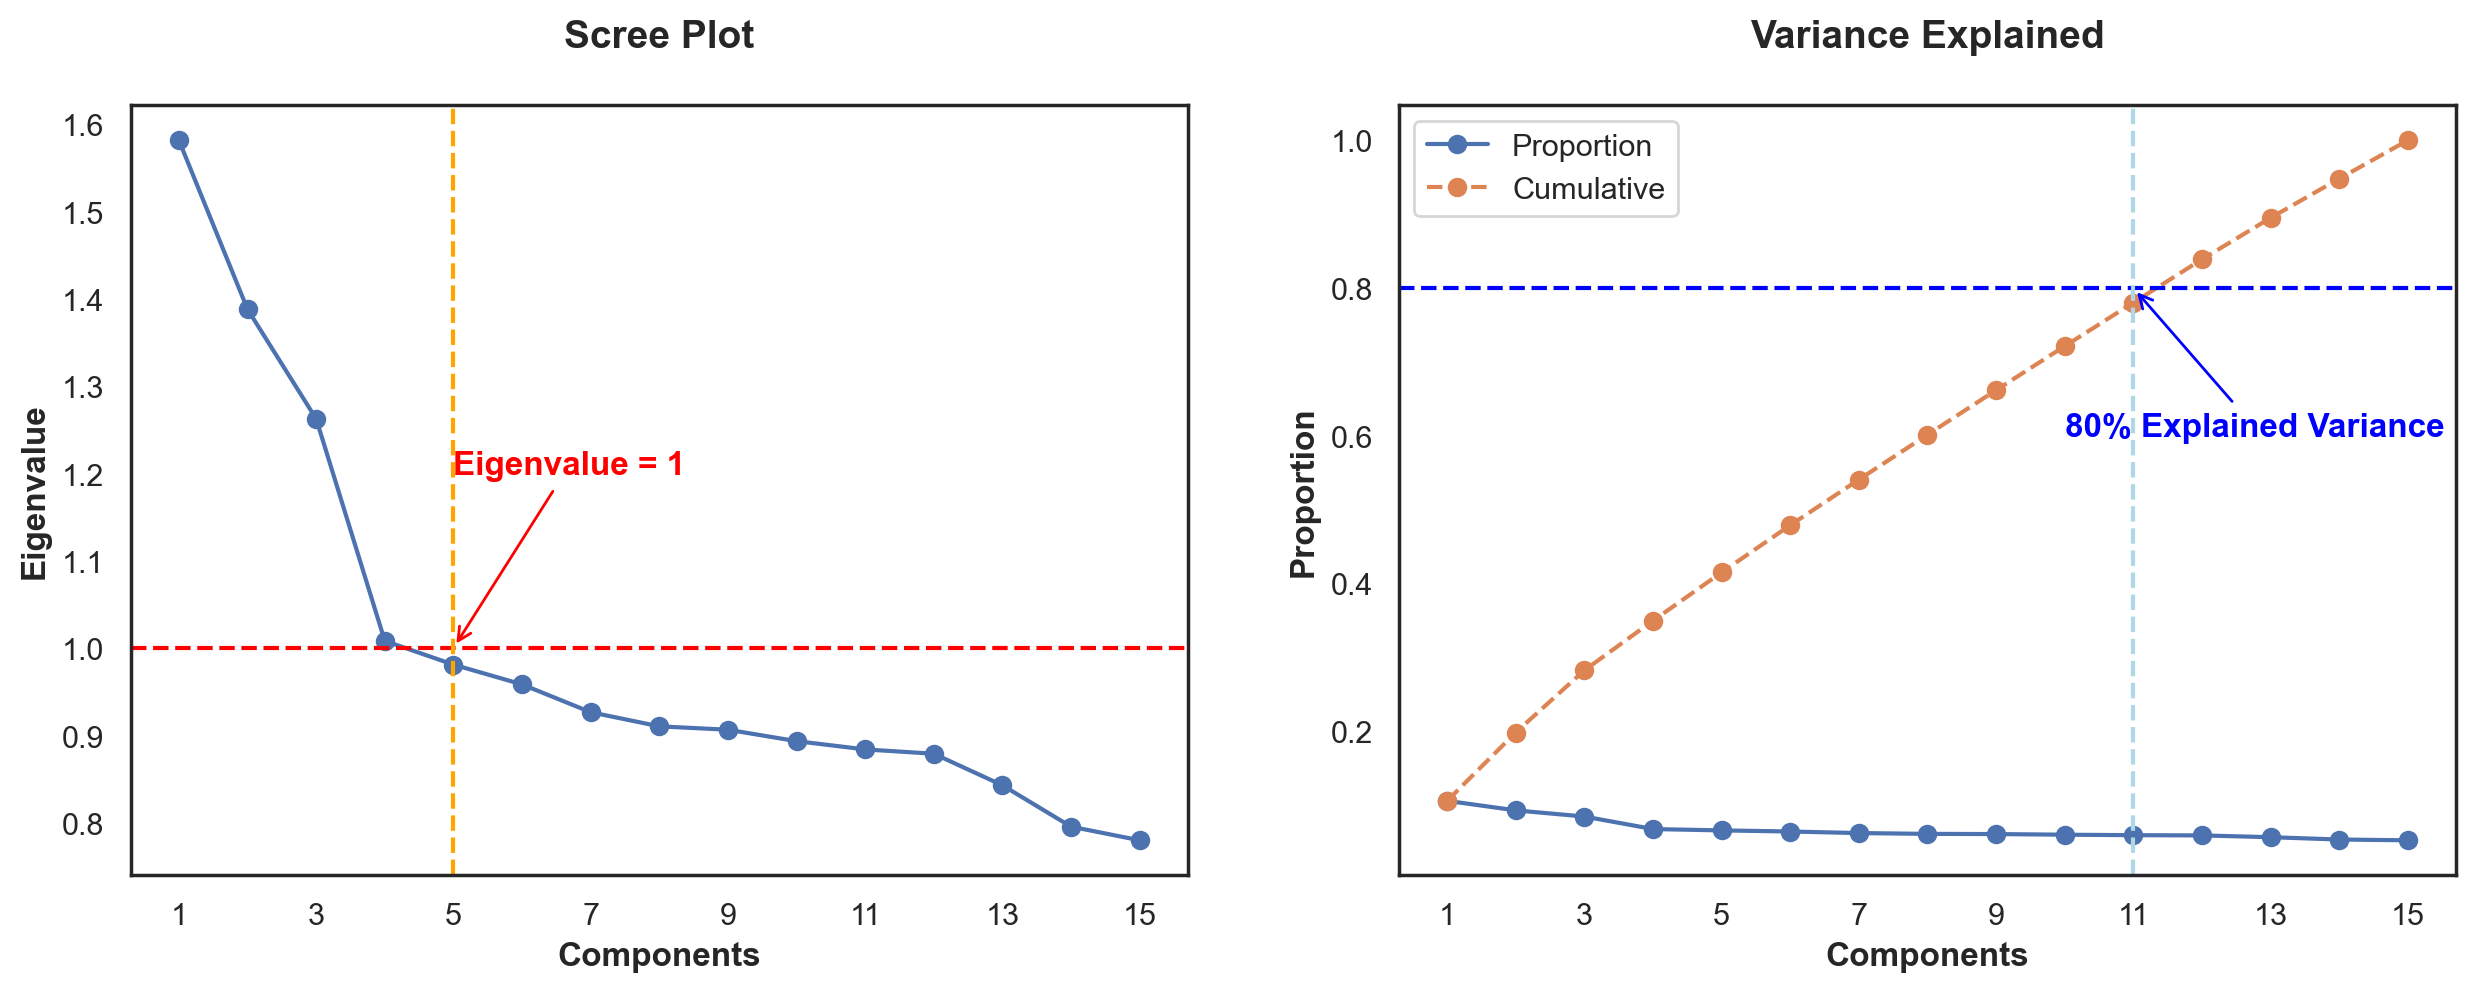

In [69]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio, # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio, # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot\n", fontsize=14, fontweight="bold")
ax2.set_title("Variance Explained\n", fontsize=14, fontweight="bold")
ax1.set_ylabel("Eigenvalue", fontsize=12, fontweight="bold")
ax2.set_ylabel("Proportion", fontsize=12, fontweight="bold")
ax1.set_xlabel("Components", fontsize=12, fontweight="bold")
ax2.set_xlabel("Components", fontsize=12, fontweight="bold")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

# Add Lines and Annotations
ax1.axhline(1, color="red", linestyle="--")
ax1.annotate("Eigenvalue = 1", (4, 1), (4, 1.2), arrowprops={"arrowstyle": "->", "color": "red"}, fontsize=12, color="red", fontweight="bold")
ax1.axvline(4, color="orange", linestyle="--")

ax2.axhline(0.8, color="blue", linestyle="--")
ax2.annotate("80% Explained Variance", (10, 0.8), (9, 0.6), arrowprops={"arrowstyle": "->", "color": "blue"}, fontsize=12, color="blue", fontweight="bold")
ax2.axvline(10, color="lightblue", linestyle="--")

plt.show()

<div class="alert alert-block alert-info" style="font-size:16px;">

> **1st Rule of Thumb:** Keep $80\%$ of the total variance $\rightarrow$ **`n_components=11`** (Estamos a analisar o gráfico da variância acumulada - direita)

> **2nd & 3rd Rule of Thumb:** Keep the components with eigenvalues greater than 1 $\rightarrow$ $PC \;var \ge 1$ $\rightarrow$ **`n_components` = 5** (Todos os PCs que têm *Eigenvalues* maiores que 1, sem arredondar) (Confirmamos com o gráfico da esquerda - *Scree plot*)

</div>

In [70]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=11)
pca_feat = pca.fit_transform(df_pca[cuisines_cols_selected_cols])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
index,,,,,,,,,,,
0,0.91,-0.56,-0.71,0.54,3.12,0.23,-1.01,-1.73,0.55,-0.93,-0.41
1,-0.21,-0.24,-0.52,-0.39,-0.24,-0.08,-0.14,-0.10,0.13,0.50,-0.19
2,-0.14,-0.49,-0.53,-0.21,-0.22,-0.07,-0.08,-0.03,0.04,0.34,-0.14
3,0.28,-0.41,-0.56,0.39,1.89,0.20,-0.66,-1.10,0.43,-0.60,-0.18
4,-0.71,0.48,-0.35,-0.54,-0.20,0.04,-0.28,-0.29,0.42,0.57,-0.11
...,...,...,...,...,...,...,...,...,...,...,...
31883,-0.76,-0.58,0.20,0.26,0.21,-1.04,1.58,-0.54,-0.04,-0.05,-0.04
31884,-0.08,-0.16,-0.58,-0.62,-0.29,-0.15,-0.18,-0.14,0.14,0.73,-0.33
31885,-1.25,0.18,0.22,0.12,0.84,-1.12,-0.95,1.85,-1.42,-0.80,-1.50


In [71]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,-1.37,-0.41,-0.08,-0.49,-1.18,-2.70,DELIVERY,DIGI,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,4.03,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,1.93,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,2,15-28,-1.17,-1.01,True,-0.20,Indian,-0.87,0.53,0.91,-0.56,-0.71,0.54,3.12,0.23,-1.01,-1.73,0.55,-0.93,-0.41
1,5d272b9dcb,8670,-1.51,-0.41,-0.58,-0.21,-1.18,-2.70,DISCOUNT,DIGI,0.73,-0.15,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,0.82,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,8,15-28,-1.17,-1.01,True,-0.44,American,-0.19,-0.09,-0.21,-0.24,-0.52,-0.39,-0.24,-0.08,-0.14,-0.10,0.13,0.50,-0.19
2,f6d1b2ba63,4660,1.53,-0.78,-0.58,-0.21,-1.18,-2.70,DISCOUNT,CASH,0.40,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,1.13,-0.38,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,29-41,-1.17,-1.01,True,-0.68,American,-0.87,-0.73,-0.14,-0.49,-0.53,-0.21,-0.22,-0.07,-0.08,-0.03,0.04,0.34,-0.14
3,180c632ed8,4660,-0.50,-0.41,-0.41,-0.49,-1.18,-2.66,DELIVERY,DIGI,-0.44,0.17,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,2.40,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,0.71,-0.38,-0.38,1.37,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,15-28,-1.13,-0.95,True,-0.14,Indian,-0.19,0.70,0.28,-0.41,-0.56,0.39,1.89,0.20,-0.66,-1.10,0.43,-0.60,-0.18
4,4eb37a6705,4660,-1.08,-0.41,-0.08,-0.76,-1.18,-2.66,NO PROMO,DIGI,0.89,1.38,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,1.67,1.13,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,4,15-28,-1.13,-0.95,False,0.44,Asian,-0.19,2.22,-0.71,0.48,-0.35,-0.54,-0.20,0.04,-0.28,-0.29,0.42,0.57,-0.11


In [72]:
# Loadings
loadings = df_pca[cuisines_cols_selected_cols + pca_feat_names].corr().loc[cuisines_cols_selected_cols, pca_feat_names]

In [73]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color


# Interpreting each Principal Component
loadings.style.map(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
CUI_American,0.094021,0.485335,-0.061607,-0.511181,-0.087949,-0.103021,-0.123315,-0.131761,0.115387,0.454889,-0.224612
CUI_Asian,-0.422613,0.501286,0.133295,-0.046857,0.035204,0.086896,-0.072205,-0.102985,0.168840,-0.002171,0.077563
CUI_Beverages,-0.301889,0.130791,0.333668,0.016720,0.152105,-0.451103,0.648824,-0.261797,0.008103,0.007282,-0.041272
CUI_Cafe,0.405972,0.398830,-0.032743,0.134025,-0.165462,-0.224378,0.059493,-0.097080,-0.293521,-0.218519,0.372159
CUI_Chicken Dishes,0.215858,-0.212445,0.521195,-0.084094,0.198720,-0.025640,-0.165057,0.084914,-0.172922,0.543808,0.254394
CUI_Chinese,0.094776,0.036617,0.580761,-0.152112,-0.189216,0.158131,-0.008691,-0.055484,0.530738,-0.249215,-0.008709
CUI_Desserts,-0.333915,0.302135,0.202372,-0.024580,0.246003,-0.281065,-0.237221,0.424529,-0.326214,-0.175092,-0.371266
CUI_Healthy,0.101495,0.319994,0.016950,0.729040,-0.224697,-0.168215,-0.217051,0.002705,0.271357,0.231350,-0.213707
CUI_Indian,0.328863,0.076852,-0.059298,0.075441,0.758790,0.047397,-0.234165,-0.407446,0.137119,-0.191811,-0.102979
CUI_Italian,0.421519,0.197599,-0.309806,-0.364761,-0.160878,-0.122531,0.023786,0.073788,0.048249,-0.206160,-0.168439


In [74]:
pd.concat([ABCDEats_standard[metric_cols], df_pca[pca_feat_names]], axis=1)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.37,-0.41,-0.08,-0.49,-1.18,-2.70,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,4.03,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,1.93,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.17,-1.01,-0.20,-0.87,0.53,0.91,-0.56,-0.71,0.54,3.12,0.23,-1.01,-1.73,0.55,-0.93,-0.41
1,-1.51,-0.41,-0.58,-0.21,-1.18,-2.70,0.73,-0.15,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,0.82,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.17,-1.01,-0.44,-0.19,-0.09,-0.21,-0.24,-0.52,-0.39,-0.24,-0.08,-0.14,-0.10,0.13,0.50,-0.19
2,1.53,-0.78,-0.58,-0.21,-1.18,-2.70,0.40,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,0.48,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,1.13,-0.38,0.71,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.17,-1.01,-0.68,-0.87,-0.73,-0.14,-0.49,-0.53,-0.21,-0.22,-0.07,-0.08,-0.03,0.04,0.34,-0.14
3,-0.50,-0.41,-0.41,-0.49,-1.18,-2.66,-0.44,0.17,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,2.40,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,0.71,-0.38,-0.38,1.37,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.13,-0.95,-0.14,-0.19,0.70,0.28,-0.41,-0.56,0.39,1.89,0.20,-0.66,-1.10,0.43,-0.60,-0.18
4,-1.08,-0.41,-0.08,-0.76,-1.18,-2.66,0.89,1.38,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,0.46,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,1.67,1.13,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.50,-1.13,-0.95,0.44,-0.19,2.22,-0.71,0.48,-0.35,-0.54,-0.20,0.04,-0.28,-0.29,0.42,0.57,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0.37,-0.78,-0.74,-0.49,-1.18,-2.75,-0.44,-0.44,2.02,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,1.26,-0.36,-0.38,-0.42,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.72,-1.20,-1.08,-0.47,-0.87,0.99,-0.76,-0.58,0.20,0.26,0.21,-1.04,1.58,-0.54,-0.04,-0.05,-0.04
31884,-0.35,-0.78,-0.74,-0.76,-1.18,-2.75,1.21,-0.44,-0.29,-0.14,-0.24,-0.22,-0.19,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,0.28,-0.16,-0.17,-0.18,-0.24,-0.24,-0.23,-0.21,-0.21,-0.24,-0.33,-0.38,-0.41,-0.38,-0.38,-0.36,-0.38,0.78,-0.42,-0.38,-0.31,-0.26,-0.21,-0.16,-0.16,-0.72,-1.20,-1.08,-0.47,-0.87,0.99,-0.08,-0.16,-0.58,-0.62,-0.29,-0.15,-0.18,-0.14,0.14,0.73,-0.33
31885,-0.50,-0.78,-0.74,-0.49,-1.18,-2.75,-0.44,-0.44,-0.29,-0.14,-0.24,-0.22,3.77,-0.17,-0.23,-0.31,-0.33,-0.17,-0.33,-0.27,-0.21,-0.57,-0.56,-0.59,-0.60,-0.64,-0.63,0

C:\Users\André Silvestre\AppData\Local\Temp\ipykernel_17104\2117207016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd.concat([ABCDEats_standard[metric_cols], df_pca[pca_feat_names]], axis=1).mean().sort_values(ascending=False).abs()[['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']], palette='viridis', orient='h')


<Axes: >

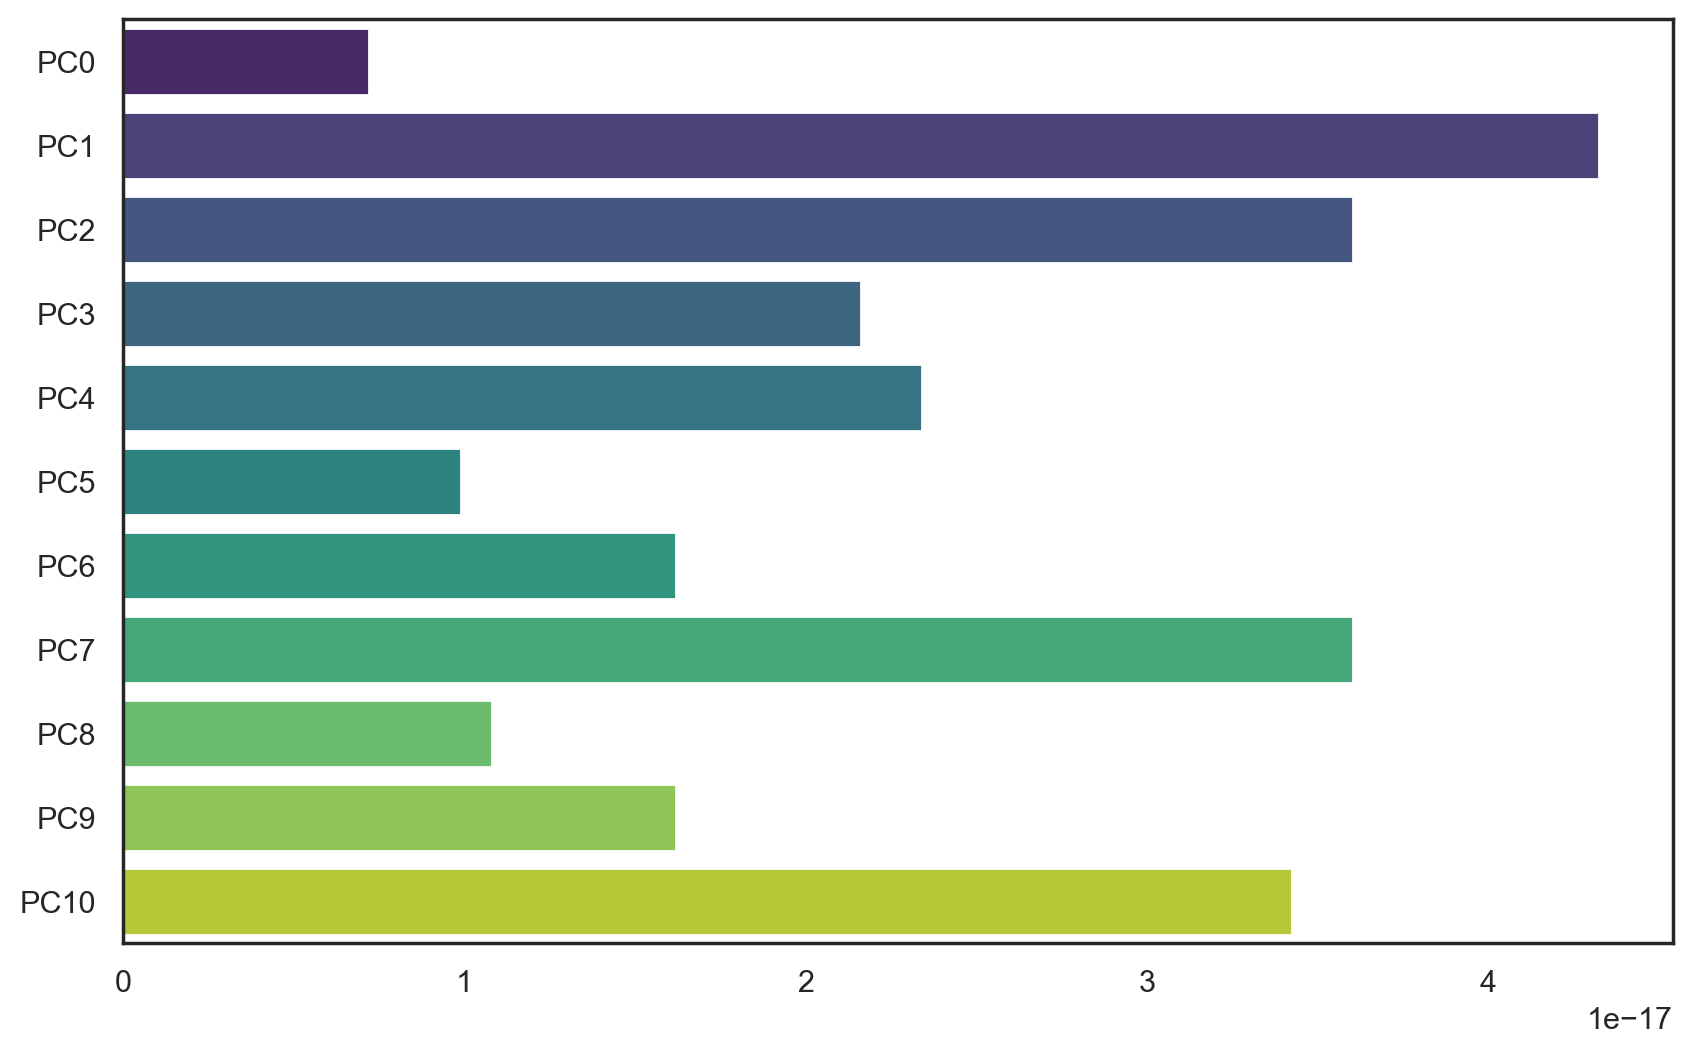

In [75]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(pd.concat([ABCDEats_standard[metric_cols], df_pca[pca_feat_names]], axis=1).mean().sort_values(ascending=False).abs()[['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']], palette='viridis', orient='h')

---

# **💾 Save Data** 

<br>

- To finish this notebook and proceed Cluster Analysis, we will save the data to a new file.

In [76]:
# Save the preprocessed dataset
# ABCDEats.to_parquet('data/DM2425_ABCDEats_preprocessed.parquet')